The following codes are originally from [here](https://bipinkrishnan.github.io/ml-recipe-book/object_detection.html), and slightly modified

In this chapter we will train a model to detect cars present in an image. For each car present in the image, the model should predict the bounding box that encloses the car.

For each bounding box, the model should predict 4 numbers/coordinates(`xmin`, `ymin`, `xmax`, `ymax`). As you can see from the detailed figure below, `xmin` and `ymin` represents the top left coordinate of the bounding box, where as, `xmax` and `ymax` represents the bottom right coordinates of the bounding box:

<img src="images/object_detect_model.png" style="width:700px;height:500px;background-color:white">

# 0. Dataset

All the images for our training set is under `training_images` folder and its bounding box coordinates can be found in `train_solution_bounding_boxes (1).csv`.

The first column represents the name of the image and the remaining 4 columns represent the coordinates of the bounding box for that image.

# 1. Preparing the dataframe

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/car-object-detection/train_solution_bounding_boxes (1).csv")
df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In the above dataframe, there are multiple rows with the same image name. This means that there are certain images that has multiple bounding boxes(for multuple cars).

We will combine all those bounding boxes together, but, before that let’s create a column that contains the area of the bounding boxes, for that we need the height and width of the bounding boxes:

In [3]:
df["bbox_width"] = df["xmax"] - df["xmin"]
df["bbox_height"] = df["ymax"] - df["ymin"]

Now let’s calculate the area and store it in a new column:

In [4]:
df["area"] = df["bbox_width"] * df["bbox_height"]

In [5]:
df.head()

,image,xmin,ymin,xmax,ymax,bbox_width,bbox_height,area
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,46.468886,36.190476,1681.731098
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,105.166425,49.395109,5194.707092
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180,122.775687,59.665380,7325.458007
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575,133.536903,59.176319,7902.222397
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422,115.927641,51.840412,6009.736653


Now we will group and put all bounding boxes of same image in a single row instead of multiple rows:

In [6]:
df = df.groupby("image").agg(list)
df.reset_index(inplace=True)

In [7]:
df.head()

,image,xmin,ymin,xmax,ymax,bbox_width,bbox_height,area
0,vid_4_1000.jpg,[281.2590449],[187.0350708],[327.7279305],[223.225547],[46.46888560000002],[36.190476200000006],[1681.7310983473237]
1,vid_4_10000.jpg,[15.16353111],[187.0350708],[120.3299566],[236.4301802],[105.16642549000001],[49.395109399999996],[5194.707092285498]
2,vid_4_10020.jpg,[496.4833575],[172.3632561],[630.0202605],[231.5395753],[133.53690299999994],[59.176319199999995],[7902.222396907433]
3,vid_4_10040.jpg,[239.1924747],[176.7648005],[361.9681621],[236.4301802],[122.77568739999998],[59.66537969999999],[7325.458006649504]
4,vid_4_10060.jpg,[16.63096961],[186.5460103],[132.5586107],[238.3864221],[115.92764109000001],[51.8404118],[6009.736653108201]


In [8]:
# Sample with multiple boxes
df.query("image == 'vid_4_26460.jpg'")

,image,xmin,ymin,xmax,ymax,bbox_width,bbox_height,area
215,vid_4_26460.jpg,"[0.0, 34.72937771, 179.5166425, 197.1259045, 3...","[194.8600386, 191.4366152, 202.6850064, 192.90...","[42.55571635, 84.62228654, 252.8885673, 319.90...","[232.5176963, 226.6489704, 230.5614543, 233.98...","[42.55571635, 49.89290883, 73.37192480000002, ...","[37.657657700000016, 35.21235519999999, 27.876...","[1602.548599486594, 1756.8468276831761, 2045.3..."


Since the dataframe is ready, let’s split it into training and validation sets:

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_df, val_df = train_test_split(df, test_size=0.1, shuffle=False)
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

# 2. Loading the images and bounding boxes

Now we will write a data set loading class with pytorch. This class will take the dataframe(either training or validation), root path where the images are present and some augmentations/transforms to apply to the image.

Before writing the whole dataset loading class, let’s take a sample image and it’s bounding boxes from the dataframe to see what is really happening while loading our data.

1) First let’s take a sample image containing multiple bounding boxes:

In [11]:
sample = train_df.iloc[215]
img_name = sample["image"]
bboxes = sample[["xmin", "ymin", "xmax", "ymax"]].values

In [12]:
sample

index                                                        215
image                                            vid_4_26460.jpg
xmin           [0.0, 34.72937771, 179.5166425, 197.1259045, 3...
ymin           [194.8600386, 191.4366152, 202.6850064, 192.90...
xmax           [42.55571635, 84.62228654, 252.8885673, 319.90...
ymax           [232.5176963, 226.6489704, 230.5614543, 233.98...
bbox_width     [42.55571635, 49.89290883, 73.37192480000002, ...
bbox_height    [37.657657700000016, 35.21235519999999, 27.876...
area           [1602.548599486594, 1756.8468276831761, 2045.3...
Name: 215, dtype: object

In [13]:
bboxes

array([list([0.0, 34.72937771, 179.5166425, 197.1259045, 364.4138929, 473.4934877, 563.4963821]),
       list([194.8600386, 191.4366152, 202.6850064, 192.9037967, 181.6554054, 185.5678893, 177.253861]),
       list([42.55571635, 84.62228654, 252.8885673, 319.9015919, 454.4167873, 573.2793054, 652.5209841]),
       list([232.5176963, 226.6489704, 230.5614543, 233.9848777, 219.8021236, 227.1380309, 213.9333977])],
      dtype=object)

2) We will read the image using opencv, convert it to RGB format and normalize it:

In [14]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

In [15]:
# root path where images are present
img_root_path = Path("../data/car-object-detection/training_images")

In [16]:
img = cv2.imread(str(img_root_path / img_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

In [17]:
img.shape

(380, 676, 3)

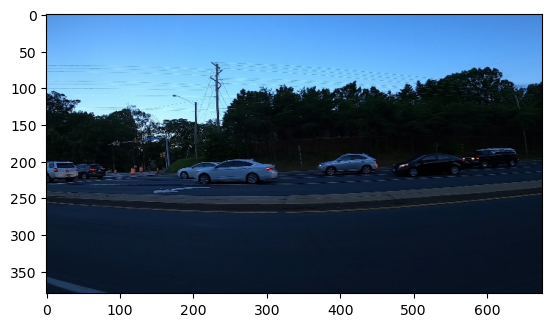

In [18]:
plt.imshow(img)

3) Since our bounding box coordinates are in a list format, let’s convert all of them into pytorch tensor and store it in tuple format:

In [19]:
import torch

In [20]:
bboxes = tuple(map(torch.tensor, zip(*bboxes)))

In [21]:
bboxes

(tensor([  0.0000, 194.8600,  42.5557, 232.5177]),
 tensor([ 34.7294, 191.4366,  84.6223, 226.6490]),
 tensor([179.5166, 202.6850, 252.8886, 230.5614]),
 tensor([197.1259, 192.9038, 319.9016, 233.9849]),
 tensor([364.4139, 181.6554, 454.4168, 219.8021]),
 tensor([473.4935, 185.5679, 573.2793, 227.1380]),
 tensor([563.4964, 177.2539, 652.5210, 213.9334]))

Each tensor represents the `xmin`, `ymin`, `xmax` and `ymax` of a bounding box. Having 7 tensors means that we have 7 bounding boxes in total.

4) Now we will stack all the above tensors into a single tensor of shape (7, 4):

In [22]:
bboxes = torch.stack(bboxes, dim=0)

In [23]:
bboxes

tensor([[  0.0000, 194.8600,  42.5557, 232.5177],
        [ 34.7294, 191.4366,  84.6223, 226.6490],
        [179.5166, 202.6850, 252.8886, 230.5614],
        [197.1259, 192.9038, 319.9016, 233.9849],
        [364.4139, 181.6554, 454.4168, 219.8021],
        [473.4935, 185.5679, 573.2793, 227.1380],
        [563.4964, 177.2539, 652.5210, 213.9334]])

5) We will be using a faster rcnn model for our object detection task. This model requires the class/label corresponding to each bounding box. Thus, corresponding to each bounding box in an image, we should provide a label. In our case we only have bounding boxes for car, so we only have one label. The label 0 is reserved for background, so we will use 1 as the label for car.

So, let’s create a tensor containing 1s that has the same length as the number of bounding boxes in the image:

In [24]:
labels = torch.ones(len(bboxes), dtype=torch.int64)

In [25]:
labels

tensor([1, 1, 1, 1, 1, 1, 1])

6) Now, let’s define the transforms/augmentations that we wish to apply to the image. We will use the ‘albumentations’ library for this. We will resize the image and convert it to tensors.

Since this is an object detection task, we cannot simply resize the image without resizing the bounding boxes. But albumentations will automatically take care of this if we pass the `bbox` parameter to our transforms, it requires the bounding box format we are using as well as the key to store the labels.

> Note: The bounding box format we are using is (`xmin`, `ymin`, `xmax`, `ymax`) which is the ‘pascal voc’ format.

In [26]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [27]:
transforms = A.Compose(
    [
        A.Resize(256, 256, p=1.0),  # resize the image
        ToTensorV2(p=1.0),
    ],
    bbox_params={"format": "pascal_voc", "label_fields": ["labels"]},
)  # bounding box parameters

In [28]:
augmented = transforms(image=img, bboxes=bboxes, labels=labels)

In [29]:
augmented

{'image': tensor([[[0.3294, 0.3234, 0.3255,  ..., 0.2673, 0.2721, 0.2809],
          [0.3266, 0.3291, 0.3312,  ..., 0.2760, 0.2798, 0.2858],
          [0.3286, 0.3325, 0.3364,  ..., 0.2758, 0.2821, 0.2776],
          ...,
          [0.0469, 0.0465, 0.0434,  ..., 0.0352, 0.0336, 0.0312],
          [0.0455, 0.0447, 0.0435,  ..., 0.0314, 0.0327, 0.0314],
          [0.0431, 0.0431, 0.0435,  ..., 0.0314, 0.0314, 0.0314]],
 
         [[0.5765, 0.5822, 0.5843,  ..., 0.5301, 0.5207, 0.5240],
          [0.5822, 0.5879, 0.5900,  ..., 0.5330, 0.5283, 0.5289],
          [0.5874, 0.5922, 0.5961,  ..., 0.5307, 0.5320, 0.5232],
          ...,
          [0.0805, 0.0801, 0.0787,  ..., 0.0705, 0.0689, 0.0665],
          [0.0797, 0.0794, 0.0788,  ..., 0.0667, 0.0680, 0.0667],
          [0.0745, 0.0763, 0.0788,  ..., 0.0667, 0.0667, 0.0667]],
 
         [[0.8863, 0.8881, 0.8902,  ..., 0.8477, 0.8444, 0.8495],
          [0.8891, 0.8938, 0.8959,  ..., 0.8535, 0.8520, 0.8544],
          [0.8933, 0.8980, 0.90

The output will be a dictionary containing labels, augmented image and bounding boxes.

7) After augmentation, the bounding boxes are stored in a list as tuples. But our model expects them as stacked tensors. So, we have to convert the bounding boxes to that format.

We will convert each bounding box to tensor format, store them in a tuple and then stack them to a single tensor as we did earlier:

In [30]:
# convert to tensor
bboxes = map(torch.tensor, zip(*augmented["bboxes"]))
# store as tuples
bboxes = tuple(bboxes)
# stack into a single tensor
bboxes = torch.stack(bboxes, dim=0)

8) Now let’s convert the data types to the format as required by the model(otherwise we will get errors while training):

In [31]:
bboxes

tensor([[  0.0000,  13.1520,  67.9826,  74.6512, 138.0029, 179.3111, 213.3951],
        [131.2741, 128.9678, 136.5457, 129.9562, 122.3784, 125.0142, 119.4131],
        [ 16.1158,  32.0463,  95.7684, 121.1462, 172.0868, 217.0999, 247.1085],
        [156.6435, 152.6898, 155.3256, 157.6319, 148.0772, 153.0193, 144.1236]],
       dtype=torch.float64)

In [32]:
bboxes.shape

torch.Size([4, 7])

In [33]:
img = augmented["image"].type(torch.float32)
bboxes = bboxes.permute(1, 0).type(torch.float32)

In [34]:
bboxes

tensor([[  0.0000, 131.2741,  16.1158, 156.6435],
        [ 13.1520, 128.9678,  32.0463, 152.6898],
        [ 67.9826, 136.5457,  95.7684, 155.3256],
        [ 74.6512, 129.9562, 121.1462, 157.6319],
        [138.0029, 122.3784, 172.0868, 148.0772],
        [179.3111, 125.0142, 217.0999, 153.0193],
        [213.3951, 119.4131, 247.1085, 144.1236]])

9) Our image, bounding boxes and its labels are ready. But the model expects some more elements apart from these, which includes ‘area’ and ‘iscrowd’.

The term ‘area’ is nothing but the area of the bounding box. We have already calculated it earlier, so let’s just take it and convert to a pytorch tensor:

In [35]:
area = sample["area"]
area = torch.as_tensor(area, dtype=torch.float32)

In [36]:
area

tensor([1602.5486, 1756.8468, 2045.3486, 5043.7578, 3433.3149, 4148.1104,
        3265.3811])

But what is this ‘iscrowd’ element? This element is helpful if we want our model to exclude certain bounding boxes.

If ‘iscrowd’ is 1, that bounding box is not considered by the model. But we want the model to consider all bounding boxes. So we will put the value 0 for ‘iscrowd’ corresponding to each bounding box:

> Personal Note: 'iscrowd' might be useful for training model with multiple classes

In [37]:
iscrowd = torch.zeros(len(bboxes), dtype=torch.int)

10) Since everything is ready, lets create a dictionary and store all the target data there:

In [38]:
target = {}
target["boxes"] = bboxes
target["labels"] = labels
target["area"] = area
target["iscrowd"] = iscrowd

In [39]:
target

{'boxes': tensor([[  0.0000, 131.2741,  16.1158, 156.6435],
         [ 13.1520, 128.9678,  32.0463, 152.6898],
         [ 67.9826, 136.5457,  95.7684, 155.3256],
         [ 74.6512, 129.9562, 121.1462, 157.6319],
         [138.0029, 122.3784, 172.0868, 148.0772],
         [179.3111, 125.0142, 217.0999, 153.0193],
         [213.3951, 119.4131, 247.1085, 144.1236]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
 'area': tensor([1602.5486, 1756.8468, 2045.3486, 5043.7578, 3433.3149, 4148.1104,
         3265.3811]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)}

> Note: Make sure that the keys of the target dictionary has the same name as above, because the model expects it that way.

Now let’s wrap everything into our data set loading class:

In [40]:
from torch.utils.data import Dataset

In [41]:
class LoadDataset(Dataset):
    def __init__(self, df, img_dir, transforms):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # read & process the image
        filename = self.df.loc[idx, "image"]
        img = cv2.imread(str(self.img_dir / filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

        # get the bboxes
        bboxes = self.df.loc[idx, ["xmin", "ymin", "xmax", "ymax"]].values
        bboxes = tuple(map(torch.tensor, zip(*bboxes)))
        bboxes = torch.stack(bboxes, dim=0)

        # create labels
        labels = torch.ones(len(bboxes), dtype=torch.int64)
        # apply augmentations
        augmented = self.transforms(image=img, bboxes=bboxes, labels=labels)

        # convert bbox list to tensors again
        bboxes = map(torch.tensor, zip(*augmented["bboxes"]))
        bboxes = tuple(bboxes)
        bboxes = torch.stack(bboxes, dim=0)

        img = augmented["image"].type(torch.float32)
        bboxes = bboxes.permute(1, 0).type(torch.float32)
        iscrowd = torch.zeros(len(bboxes), dtype=torch.int)

        # bbox area
        area = self.df.loc[idx, "area"]
        torch.as_tensor(area, dtype=torch.float32)

        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

Finally, let’s load the training and validation datasets:

In [42]:
train_ds = LoadDataset(train_df, img_root_path, transforms)
val_ds = LoadDataset(val_df, img_root_path, transforms)

# 3. Training the model

For the model, we will use a pretrained faster rcnn model with `resnet50` backbone. In our case, we only have two classes, 0 for background and 1 for car, thus, we will slightly modify the number of units in the last layer as shown below:

In [43]:
from torchvision.models.detection import (
    FasterRCNN_ResNet50_FPN_Weights,
    fasterrcnn_resnet50_fpn,
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [44]:
# load pretrained model
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

In [45]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [46]:
# get input features of prediction layer
in_features = model.roi_heads.box_predictor.cls_score.in_features

In [47]:
in_features

1024

In [48]:
# modify the prediction layer with required number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

In [49]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

Now let’s build the model class.

As usual we will write our `__init__` method, which includes the batch size, learning rate and the model. For model creation, we will use a method called `create_model()` which will contain the code we’ve written above.

In [50]:
from pytorch_lightning import LightningModule
from torch.utils.data import DataLoader
from torchvision.ops import box_iou

In [51]:
class ObjectDetector(LightningModule):
    def __init__(self):
        super().__init__()
        self.lr = 1e-3
        self.batch_size = 16
        self.model = self.create_model()
        self.validation_step_outputs = []  # Added by me

    def create_model(self):
        model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
        return model

    def forward(self, x):
        return self.model(x)

    # The number of bounding boxes may be different for each image,
    # so, we will need a collate_fn to pass to our dataloaders.
    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def train_dataloader(self):
        return DataLoader(
            train_ds, 
            batch_size=self.batch_size, 
            shuffle=True, 
            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            val_ds, 
            batch_size=self.batch_size, 
            shuffle=False, 
            collate_fn=self.collate_fn
        )
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)

    # For training, instead of giving only the predictions,
    # the model outputs a bunch of loss values.
    # So, we should sum all these losses together and
    # return it in training step for backward propagation.
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        loss_dict = self.model(inputs, targets)
        complete_loss = sum(loss for loss in loss_dict.values())

        self.log("train_loss", complete_loss, prog_bar=True)
        return {"loss": complete_loss}

    # During validation, pytorch lightning automatically calls model.eval() for us.
    # While doing this, the behaviour of the model will change again.
    # This time, the model will output the bounding box prediction and probabilites of our label(car).
    # So we need to take this into account while implementing the validation step.

    # So, during validation, we take the predicted bounding box coordinates and the target bounding boxes
    # to calculate intersection over union(IOU) which is a commonly used metric for object detection.
    # We will be using box_iou function from torchvision for calculating IOU.

    # IOU varies from 0 to 1, values closer to 0 are considered bad
    # whereas the ones closer to 1 are considered good predictions.
    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.model(inputs)
        # calculate IOU and return the mean IOU
        iou = torch.stack(
            [
                box_iou(target["boxes"], output["boxes"]).diag().mean()
                for target, output in zip(targets, outputs)
            ]
        ).mean()
        self.validation_step_outputs.append(iou)  # Added by me
        
        return {"val_iou": iou}

    # So, from validation_step() we will get the IOU for each batch,
    # this is appended to a list and passed to validation_epoch_end().
    # So, the only task remaining is to calculate the mean IOU from the list
    # passed to validation_epoch_end() and log it:
    def on_validation_epoch_end(self):  # modified by me
        # calculate overall IOU across batch
        # val_iou = torch.stack([o["val_iou"] for o in val_out]).mean()  # Removed by me
        val_iou = torch.stack(self.validation_step_outputs).mean()  # Added by me
        self.validation_step_outputs.clear()  # free memory
        self.log("val_iou", val_iou, prog_bar=True)
        return val_iou

Now it’s time to train the model using the lightning trainer:

In [52]:
from pytorch_lightning import Trainer

In [53]:
detector_model = ObjectDetector()

In [54]:
trainer = Trainer(
    accelerator="auto",
    devices=1,
    # auto_lr_find=True,  # (Not availabe in version 2.0.2)
    max_epochs=5,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [55]:
trainer.fit(detector_model)


  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\johnw\miniconda3\envs\opencv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


# 4. Testing the model

In [56]:
import matplotlib.pyplot as plt

In [57]:
sample = val_ds[14]
img = sample[0]

In [58]:
sample

(tensor([[[0.7658, 0.7657, 0.7676,  ..., 0.6667, 0.6667, 0.6667],
          [0.7745, 0.7743, 0.7793,  ..., 0.6667, 0.6667, 0.6697],
          [0.7790, 0.7814, 0.7829,  ..., 0.6674, 0.6706, 0.6738],
          ...,
          [0.1578, 0.1480, 0.1371,  ..., 0.5090, 0.5045, 0.5137],
          [0.1504, 0.1493, 0.1504,  ..., 0.5124, 0.5091, 0.5116],
          [0.1384, 0.1591, 0.1703,  ..., 0.5098, 0.5176, 0.5174]],
 
         [[0.9933, 0.9931, 0.9931,  ..., 0.9373, 0.9394, 0.9413],
          [0.9963, 0.9961, 0.9932,  ..., 0.9373, 0.9394, 0.9442],
          [0.9962, 0.9916, 0.9930,  ..., 0.9388, 0.9437, 0.9483],
          ...,
          [0.2340, 0.2424, 0.2421,  ..., 0.4318, 0.4229, 0.4241],
          [0.2421, 0.2424, 0.2441,  ..., 0.4261, 0.4228, 0.4253],
          [0.2488, 0.2384, 0.2388,  ..., 0.4235, 0.4286, 0.4311]],
 
         [[0.9970, 0.9970, 0.9970,  ..., 0.9961, 0.9919, 0.9883],
          [0.9943, 0.9943, 0.9943,  ..., 0.9961, 0.9919, 0.9913],
          [0.9913, 0.9899, 0.9913,  ...,

In [59]:
detector_model.eval()
with torch.no_grad():
    out = detector_model([img])

In [60]:
out

[{'boxes': tensor([[140.7251, 125.9845, 184.9256, 154.2681],
          [  4.3245, 125.4633,  48.6095, 158.1288],
          [151.6972, 119.0912, 196.3702, 154.2093],
          [143.3873, 108.2757, 178.4418, 160.7659],
          [ 25.9562, 127.7766,  33.4975, 144.6900],
          [146.4847, 110.0635, 212.3393, 158.0165],
          [ 23.2630, 127.3925,  31.2712, 145.3811],
          [167.2378, 123.6141, 208.5033, 150.7289],
          [ 28.5186, 127.5997,  36.0218, 144.8483],
          [ 20.9854, 124.6055,  41.3966, 155.6943],
          [ 13.6132, 124.5026,  34.1976, 156.6431],
          [ 20.5961, 128.0727,  28.5975, 146.8976],
          [ 27.6670, 129.6764,  40.5272, 142.7679],
          [ 20.5502, 130.8202,  40.3913, 139.5200],
          [127.7437, 121.0897, 169.3318, 155.5781],
          [ 10.7417, 127.2272,  40.0056, 145.3524],
          [  1.5597, 116.2106,  34.5176, 164.7354],
          [147.3165, 125.7106, 155.2097, 144.3734],
          [  8.6286, 126.2921,  26.8929, 156.7722],
   

In [61]:
# convert to numpy for opencv to draw bboxes
img = img.permute(1, 2, 0).numpy()

Get the predicted bounding boxes and labels:

In [62]:
# predicted bounding boxes
pred_bbox = out[0]["boxes"].numpy().astype(int)
# predicted labels
pred_label = out[0]["scores"]

Draw the predicted bounding boxes on the image:

In [63]:
# draw bounding boxes on the image
for bbox, label in zip(pred_bbox, pred_label):
    # check if the label corresponding to bbox is for car
    if label >= 0.5:
        cv2.rectangle(
            img,
            (bbox[0], bbox[1]),
            (bbox[2], bbox[3]),
            (255, 0, 0),
            thickness=2,
        )

Now let’s visualize the image along with the predicted bounding boxes:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


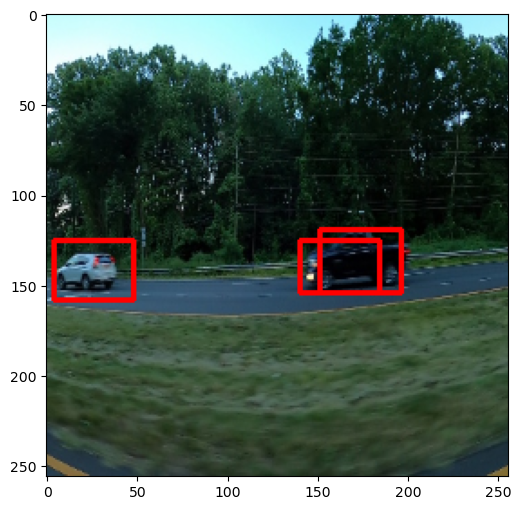

In [64]:
plt.figure(figsize=(16, 6))
plt.imshow(img)

# 5. Saving the model

In [66]:
torch.save(detector_model.state_dict(), 'detector_model_weights.pt')
torch.save(detector_model, 'detector_model.pt')